In [1]:
# general packages
import os, re, yaml
from operator import itemgetter

# scientific packages
import numpy as np
import pandas as pd # to read and work on large datasets
import matplotlib.pyplot as plt #for plots

# to allow proper LaTeX formating in figures:
from matplotlib import rc
rc('text', usetex=True)

import mushdynamics as md

Let's define some useful functions for the figures and calculations (most of them are in the scripts/figures.py) 

In [3]:
regex = re.compile(r'\d+')
def find_float(filename):
    numbers = regex.findall(filename) # gives 2 numbers as number with format "1.05" returns 1 and 05
    return float(numbers[0] + '.' + numbers[1])

def extract_files(subfolder):
        list_files = os.listdir(subfolder)
        timesteps = {}
        for file in list_files:
            if file[-14:] == "statistics.txt":
                file_stat = subfolder + "/" + file
            elif file[-9:] == ".timestep":
                _name = subfolder + "/" + file
                _time = find_float(file)
                timesteps[_name] = _time
            elif file[-5:] == ".yaml":
                with open(subfolder + "/" + file, 'r') as stream:
                    try:
                        param = yaml.safe_load(stream)
                    except yaml.YAMLError as exc:
                        print(exc)
        return file_stat, param, timesteps
    
def diagram(df, ylim=[-2, 2.5], xlim=[-4, 3], N=50):
    """ Build the regime diagram from the data frame df """
    
    x = np.log10(np.array(df["dot_r"].values).astype(float))
    y = np.log10(np.array(df["Ric_adim"].values).astype(float)) # radius IC
    delta = np.log10(np.array(df["delta"].values).astype(float)/np.array(df["Ric_adim"].values).astype(float))
    phi = np.array(df["sum_phi"].values).astype(float) # 
    phir = np.array(df["phi_r"].values).astype(float) # 
    
    fig, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 3])
    cmap = plt.cm.magma
    cntr1 = ax[0].tricontourf(x, y, delta, levels=np.linspace(-4, 4, N),  cmap=cmap)
    cntr2 = ax[1].tricontourf(x, y, phi, levels=np.linspace(0, 0.4, N),  cmap=cmap)
    cbar1 = plt.colorbar(cntr1, ax=ax[0], ticks=np.linspace(-4, 4, 9))
    cbar1.ax.set_ylabel("$\ln_{10}\delta_{ul}/ R_{{ic}}$")
    cbar2 = plt.colorbar(cntr2, ax=ax[1], ticks=[0., 0.1, 0.2, 0.3, 0.4])
    cbar2.ax.set_ylabel(r"$<\phi>$")
    ax[0].set_title("Thickness of upper layer")
    ax[1].set_title("Average porosity")
    ax[0].set_xlabel(r"$\ln_{10}\dot{R}_{{ic}}( \tau_{{ic}})/V_D$")
    ax[0].set_ylabel(r"$\ln_{10}R_{{ic}}/\delta$")
    ax[1].set_xlabel(r"$\ln_{10}\dot{R}_{{ic}}( \tau_{{ic}})/V_D$")
    ax[0].set_ylim(ylim)
    ax[0].set_xlim(xlim)
    return fig, ax


def thickness(phi, R):
    phi_inverse = phi[::-1]
    dr = R[1]-R[0]
    min_phi = np.argmin(phi_inverse)
    phi_inverse = phi_inverse[0:min_phi+1]
    max_value = phi[-1]
    mean_phi = (phi_inverse[-1] + phi_inverse[0])/2
    i_middle = np.argmin(np.abs(phi_inverse-mean_phi))
    if i_middle <5:
        delta = 0.
    else:
        dphi = phi_inverse[1:] - phi_inverse[:-1]
        slope = dphi[i_middle]/dr
        delta = -mean_phi/slope
    return delta


def diagram_data_residual_porosity(folder_main, output="data.csv"):
    """ Extract all the statistics at the end of run
    
    from a folder containing several output folders. 
    """
    
    columns = ["Ric_adim", "tau_ic", "exp", "sum_phi", "delta", "Nmax", "folder", "remarks"]
    df = pd.DataFrame(columns=columns)

    def add_value(df, ric, tau, exp, phi, delta, Nmax, phi_r, phi_t, folder="", remarks=""):
        df_add = pd.DataFrame({"Ric_adim":[ric], "tau_ic":[tau], "exp":[exp], "sum_phi":[phi], "delta":[delta], 
                               "Nmax": Nmax, "phi_r": phi_r, "phi_top": phi_t, "folder":folder, "remarks": remarks})
        df = df.append(df_add)
        return df

    list_subfolder = os.listdir(folder_main)
    print("Looking through folder {}".format(folder_main))
    for subfolder_name in list_subfolder:
        
        
        if os.path.isdir(folder_main + "/" + subfolder_name):
            file_stat, param, timesteps = extract_files(folder_main+"/"+subfolder_name)
        
            data = pd.read_csv(file_stat, sep=" ", index_col=False)
            
            if data["thickness_boundary"].iloc[-1] < 1e-12:
                print("no boundary for R {}, dot_R {}: folder {}".format(param["Ric_adim"], param['coeff_velocity'], folder_main + "/" +subfolder_name))
            elif np.abs(data["radius"].iloc[-1] -param["Ric_adim"])/param["Ric_adim"]>1e-2:
                print("Run not finished for R {}, dot_R {}: folder {}".format(param["Ric_adim"], param['coeff_velocity'], folder_main + "/" +subfolder_name))
                print(data["radius"].iloc[-1], param["Ric_adim"])
            else: 
                try:
                    name_max = max(timesteps.items(), key=itemgetter(1))[0] 
                except: 
                    print(timesteps.items())
                    print(subfolder_name)
                data_max = pd.read_csv(name_max, sep=" ")
                delta = thickness(data_max["porosity"].to_numpy()[:-1], data_max['radius'].to_numpy()[:-1])
                #delta = data["thickness_boundary"].iloc[-1]
                if delta ==0: 
                    print("oups, problem with delta not well defined", param["Ric_adim"], data["thickness_boundary"].iloc[-1])
                index_bottom = abs(data_max['radius'] - 0.05*param["Ric_adim"]).idxmin()
                phi_r = data_max["porosity"].iloc[index_bottom]
                index_top = abs(data_max['radius'] - 0.90*param["Ric_adim"]).idxmin()
                #index_top = abs(data_max['radius'] - (param["Ric_adim"]-delta*3)).idxmin()
                phi_t = data_max["porosity"].iloc[index_top]
                df = add_value(df, param["Ric_adim"], param['time_max'], param['growth_rate_exponent'], 
                                 data["sum_phi"].iloc[-1], delta , 
                                 data["radius_size"].iloc[-1], phi_r, phi_t, folder=subfolder_name)
        else: print("oups, not a folder: {}".format(folder_main + "/" + subfolder_name))

    df["dot_r"] = df["Ric_adim"]/df["tau_ic"]*df["exp"] 
    
    
    return df

# Supporting information for "The fate of liquids trapped during the Earth’s inner core growth"


This notebook presents the different figures in the Supporting information of the paper The fate of liquids trapped during the Earth’s inner core growth by Lasbleis, Kervazo and Choblet. 

## Scaling laws presented in the paper

First we select the global data set for the scaling law:

In [18]:
values = pd.read_csv("./data/SuppInfo_scalinglaws.csv")
values["logdot_r"]=np.log10(values["dot_r"])
values["logr"]=np.log10(values["Ric_adim"])

print(values.columns)

Index(['Unnamed: 0', 'Nmax', 'Ric_adim', 'delta', 'exp', 'folder', 'phi_r',
       'phi_top', 'remarks', 'sum_phi', 'tau_ic', 'dot_r', 'logdot_r', 'logr',
       'dR'],
      dtype='object')


In [21]:
values["dR"] = values["Ric_adim"]/values["Nmax"]
print(values[["Ric_adim", "dR", "delta"]])

      Ric_adim        dR         delta
0   316.227766  0.031623  1.305027e-01
1    10.000000  0.002002  8.217026e+06
2    10.000000  0.002002  1.260637e-01
3   100.000000  0.006669  3.480767e+02
4   100.000000  0.010000  1.245368e-01
5   100.000000  0.005000  2.523899e+01
6    31.622777  0.003162  1.253790e-01
7   100.000000  0.005000  3.839270e-02
8    31.622777  0.003162  2.502127e-01
9    10.000000  0.002002  2.524443e-01
10   31.622777  0.003162  3.800965e-02
11   10.000000  0.002000  2.143770e-02
12   31.622777  0.003162  2.125935e-02
13  316.227766  0.031623  1.297487e-01
14  100.000000  0.010000  6.783414e-02
15   31.622777  0.003162  1.250861e-01
16   31.622777  0.002108  7.227349e-03
17  100.000000  0.010000  6.790266e-02
18   31.622777  0.003162  6.810460e-02
19   31.622777  0.003162  3.805308e-02
20   31.622777  0.003162  6.802890e-02
21   10.000000  0.002001  3.807113e-02
22   10.000000  0.002002  6.828809e-02
23   10.000000  0.002000  2.147140e-02
24  100.000000  0.006666 

### for the linear cases: 

[ 4995 10000  5000 10001 15000  4996 15001 14998  9999 19998  4998]


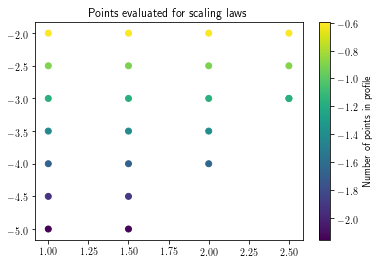

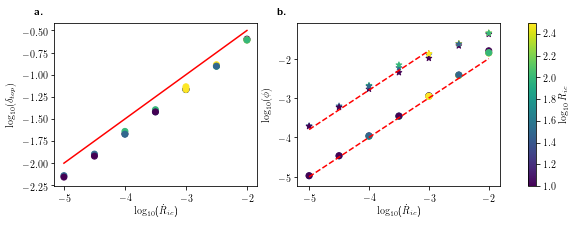

In [17]:
# select data for exp = 1
exp1 = values[values["exp"]==1.]
exp1 = exp1[exp1["logdot_r"]<-1.]

logR = np.log10(exp1["Ric_adim"])
logdot_r = np.log10(exp1["dot_r"])
logdelta = np.log10(exp1["delta"])
logphi = np.log10(exp1["sum_phi"])
logphir = np.log10(exp1["phi_r"])
logphit = np.log10(exp1["phi_top"])
tauic = np.log10(exp1["tau_ic"])

fig, ax = plt.subplots()
sc = ax.scatter(logR, logdot_r, c=logdelta)
ax.set_title("Points evaluated for scaling laws")
fig.colorbar(sc, ax=ax, label="Number of points in profile")

fig, ax = plt.subplots(1, 2, figsize=[10, 3])
sc = ax[0].scatter(logdot_r, logdelta, c=logR)
ax[0].plot([-5, -2], [-2, -0.5], 'r')
ax[1].plot([-5, -2], [-5, -2], 'r--')
ax[1].plot([-5, -3], [-3.8, -1.8], 'r--')
#sc = ax[1].scatter(logdot_r, logphi, c=logR)
#sc = ax[1].scatter(logdot_r, logphi, c=logR, marker="^")
sc = ax[1].scatter(logdot_r, logphir, c=logR, marker="*")
sc = ax[1].scatter(logdot_r, logphit, c=logR)
ax[0].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
ax[0].set_ylabel("$\log_{10}(\delta_{top})$")
#ax[1].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
#ax[1].set_ylabel("$\log_{10}(<\phi>)$")
ax[1].set_ylabel("$\log_{10}(\phi)$")
ax[1].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")

cb = fig.colorbar(sc, ax=ax.ravel().tolist(), label="$\log_{{10}} R_{{ic}}$")

ax[0].text(-0.1, 1.10, r"\textbf{a.}", transform=ax[0].transAxes, fontsize=11,
                verticalalignment='top')
ax[1].text(-0.1, 1.10, r"\textbf{b.}", transform=ax[1].transAxes, fontsize=11,
                verticalalignment='top')

plt.savefig("SuppInfo_Fig1.pdf")

__Fig S1:__  Scaling law for linear case. [a] Thickness of the uppermost layer $\delta_{ul}$ as function of the growth rate for different value of $R_{ic}/\delta$, with the theoritical slope of 1/2 shown by the solid red line. [b] Porosity estimates (stars: porosity at the center; circles: porosity at the base of the uppermost layer), with theoritical slope of 1 for the scaling laws in dashed red lines (for center and top porosity). The porosity at the center is taken at a radius of $0.05R_{{ic}}$ and the porosity at the top at $0.90R_{ic}$.

### for the $\sqrt t $ case:

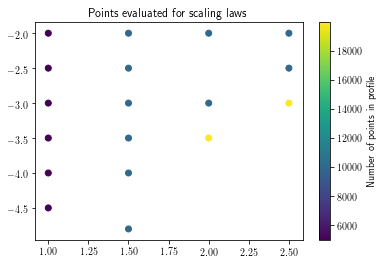

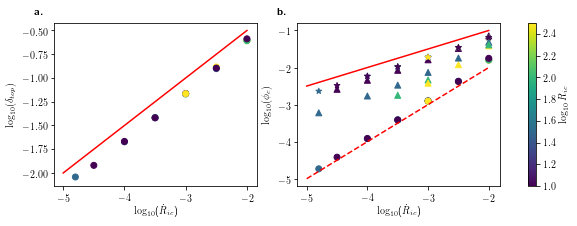

In [14]:
# select data for exp = 1
exp1 = values[values["exp"]==0.5]
exp1 = exp1[exp1["logr"]>0.8]
exp1 = exp1[exp1["logdot_r"]<-1.]

logR = np.log10(exp1["Ric_adim"])
logdot_r = np.log10(exp1["dot_r"])
logdelta = np.log10(exp1["delta"])
logphi = np.log10(exp1["sum_phi"])
logphir = np.log10(exp1["phi_r"])
logphit = np.log10(exp1["phi_top"])
tauic = np.log10(exp1["tau_ic"])

fig, ax = plt.subplots()
sc = ax.scatter(logR, logdot_r, c=exp1["Nmax"])
ax.set_title("Points evaluated for scaling laws")
fig.colorbar(sc, ax=ax, label="Number of points in profile")

fig, ax =plt.subplots(1, 2, figsize=[10, 3])
sc = ax[0].scatter(logdot_r, logdelta, c=logR)
ax[0].plot([-5, -2], [-2, -0.5], 'r')
ax[1].plot([-5, -2], [-5, -2], 'r--')
ax[1].plot([-5, -2], [-2.5, -1.], 'r')
# sc = ax[1].scatter(logdot_r, logphi, c=logR)
sc = ax[1].scatter(logdot_r, logphi, c=logR, marker="^")
sc = ax[1].scatter(logdot_r, logphir, c=logR, marker="*")
sc = ax[1].scatter(logdot_r, logphit, c=logR)
ax[0].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
ax[0].set_ylabel("$\log_{10}(\delta_{top})$")
#ax[1].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")
#ax[1].set_ylabel("$\log_{10}(<\phi>)$")
ax[1].set_ylabel("$\log_{10}(\phi)$")
ax[1].set_xlabel("$\log_{10}$($\dot R_{{ic}}$)")

cb = fig.colorbar(sc, ax=ax.ravel().tolist(), label="$\log_{{10}} R_{{ic}}$")

ax[0].text(-0.1, 1.10, r"\textbf{a.}", transform=ax[0].transAxes, fontsize=11,
                verticalalignment='top')
ax[1].text(-0.1, 1.10, r"\textbf{b.}", transform=ax[1].transAxes, fontsize=11,
                verticalalignment='top')

plt.savefig("SuppInfo_Fig2.pdf")

__Fig S1:__  Scaling law for $\sqrt{t}$ case. [a] Thickness of the uppermost layer $\delta_{ul}$ as function of the growth rate for different value of $R_{ic}/\delta$, with the theoritical slope of 1/2 shown by the solid red line. [b] Porosity estimates (triangles: average porosity; stars: porosity at the center; circles: porosity at the base of the uppermost layer), with the theoritical slope of 1 for the scaling laws in dashed red line (for the top porosity) and the theoritical slope of 1/2 for the scaling laws in red line (for the center porosity). The average porosity is in between the two scaling laws, getting closer to the scaling law with a slope of 1 for large radii.

## Diagram for linear or $\sqrt t$ growth

Note that we run less data point for this one, which explains why it is a little bit smoother than the regime in the linear case in the manuscript.

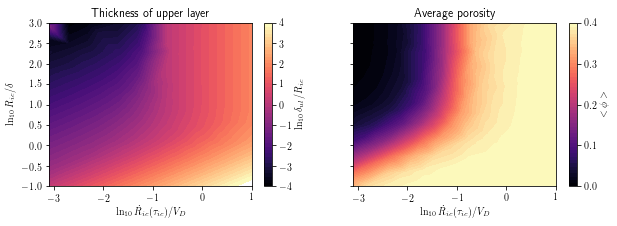

In [156]:
df_sqrtt = pd.read_csv("./data/diag_sqrtt.csv")
fig, ax = diagram(df_sqrtt, ylim=[-1, 3], xlim=[-3.1, 1])

plt.savefig("diag_n3_exp05.pdf")

## Effect of n=2 or n=3 on the results

The exponent $n$ changes the porosity profile, mostly by changing the average porosity. Overall, it does not change the thickness of the uppermost layer, and does not modify the scaling for the average porosity (but changes the value of the prefactor in the scaling law)

Here is the regime diagram for $n=2$. In the manuscript, we decided to choose $n=3$ to compare with previous results by Sumita 1996.

In [150]:
df_linear_n2 = pd.read_csv("./data/diag_linear.csv")

n = 2, similar to Bercovici, Ricard (note that the density of data is not as high as in the main paper)


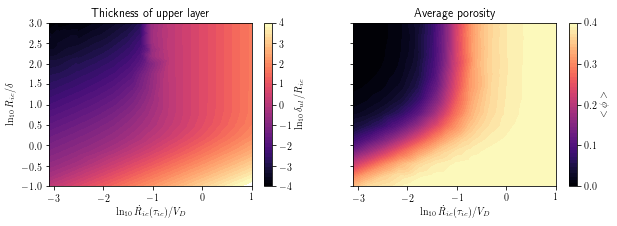

In [152]:
print("n = 2, similar to Bercovici, Ricard (note that the density of data is not as high as in the main paper)")
fig, ax = diagram(df_linear_n2, ylim=[-1, 3], xlim=[-3.1, 1])

plt.savefig("diag_n2.pdf")

## Different value of phi_0

/home/lasbleis-m/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


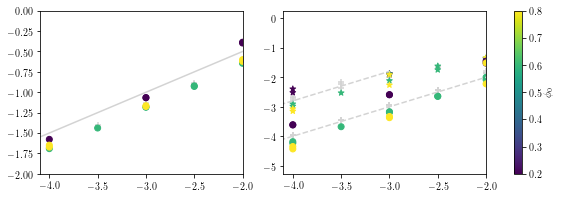

In [62]:
fig, ax = plt.subplots(1, 2, figsize=[10, 3])  # delta and average porosity for the different runs

ax[0].scatter(np.log10(exp1["dot_r"]), np.log10(exp1["delta"]), c="lightgrey", marker="+")
ax[1].scatter(np.log10(exp1["dot_r"]), np.log10(exp1["phi_r"]), c="lightgrey", marker="+")
ax[1].scatter(np.log10(exp1["dot_r"]), np.log10(exp1["phi_top"]), c="lightgrey", marker="+")

def extract_values_phi(folder):
    folder_list = os.listdir(folder)
    df = pd.DataFrame()
    for folder_single_run in folder_list:
        file_stat, param, timesteps = extract_files(folder+folder_single_run)
        param["dot_r"] = param["Ric_adim"]/param["time_max"]*param["growth_rate_exponent"]
        data = pd.read_csv(file_stat, sep=" ", index_col=False)

        name_max = max(timesteps.items(), key=itemgetter(1))[0] 
        data_max = pd.read_csv(name_max, sep=" ")
        delta = thickness(data_max["porosity"].to_numpy()[:-1], data_max['radius'].to_numpy()[:-1])
        phi = data["sum_phi"].iloc[-1]
        index_bottom = abs(data_max['radius'] - 0.05*param["Ric_adim"]).idxmin()
        phi_r = data_max["porosity"].iloc[index_bottom]
        index_top = abs(data_max['radius'] - 0.90*param["Ric_adim"]).idxmin()
        phi_t = data_max["porosity"].iloc[index_top]
        df_new = pd.DataFrame({"Ric_adim":param["Ric_adim"], "phi":[phi], "delta":[delta], "phi0":param["phi_init"],
                           "dot_r":param["dot_r"], "phi_r":phi_r, "phi_t":phi_t})
        df = df.append(df_new)
    return df

df = pd.read_csv("data/different_phi0.csv")

ax[0].scatter(np.log10(df["dot_r"]), np.log10(df["delta"]), c=(df["phi0"]))
sc = ax[1].scatter(np.log10(df["dot_r"]), np.log10(df["phi_r"]), c=(df["phi0"]), marker="*")
ax[1].scatter(np.log10(df["dot_r"]), np.log10(df["phi_t"]), c=(df["phi0"]))


#ax[2].scatter(np.log10(df["dot_r"]), np.log10(df["phi"]/df["phi0"]), c=np.log10(df["phi0"]))


ax[0].set_xlim([-4.1, -2.])
ax[0].set_ylim([-2, 0])
ax[1].set_xlim([-4.1, -2.])
#ax[2].set_xlim([-4.1, -2.])

ax[0].plot([-5, -2], [-2, -0.5], 'lightgrey')
ax[1].plot([-5, -2], [-5, -2], '--', color="lightgrey")
ax[1].plot([-5, -3], [-3.8, -1.8], '--', color="lightgrey")

cb = fig.colorbar(sc, ax=ax.ravel().tolist(), label="$\phi_0$")

plt.savefig("SuppInfo_Fig5.pdf")

In [84]:
R_dot = 1e-4

df2 = df[df["dot_r"]==R_dot]
df2 = df2[df2["Ric_adim"]==100]
#print(df2)

value = values[values["dot_r"]==R_dot]
value = value[values["Ric_adim"]==100]
value = value[value["exp"]==1.]
value_r = value["phi_r"].to_numpy()
value_t = value["phi_top"].to_numpy()

print(value_r, value_t)

df2["diff_phi_r"] = df2["phi_r"]/value_r
df2["diff_phi_t"] = df2["phi_t"]/value_t

print(df2["diff_phi_r"], df2["diff_phi_t"])

[0.00209486] [0.00010656]
9     1.920675
28    0.594742
46    0.406628
Name: diff_phi_r, dtype: float64 9     2.255066
28    0.547949
46    0.348038
Name: diff_phi_t, dtype: float64


/home/lasbleis-m/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
